# **Model Selection to estimate Agents**

For each station, find a good model to predict the individual pollutants.

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Models
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Import

In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [3]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 8,
        offset = 2
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 30


In [4]:
station_data['GIARDINI MARGHERITA']['NO2'].columns

Index(['Agent_value', 'Traffic_value', 'TAVG', 'PREC', 'RHAVG', 'RAD',
       'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

In [5]:
station_data['GIARDINI MARGHERITA']['PM2.5'].columns

Index(['Agent_value', 'Traffic_2-9', 'Traffic_10-17', 'Traffic_18-2', 'TAVG',
       'PREC', 'RHAVG', 'RAD', 'W_SCAL_INT', 'W_VEC_DIR', 'LEAFW', 'TAVG_MAX',
       'TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_rbf_1', 'month_rbf_2', 'month_rbf_3', 'month_rbf_4',
       'month_rbf_5', 'month_rbf_6', 'month_rbf_7', 'month_rbf_8',
       'month_rbf_9', 'month_rbf_10', 'month_rbf_11', 'month_rbf_12'],
      dtype='object')

As we can see for daily data we have the correct encoding of the hourly values for the traffic and the weather (like 'TAVG_MAX','TAVG_MIN', 'RHAVG_MAX', 'RHAVG_MIN') and the data encoding.

## **Training Data**

In [4]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'
RANDOM_STATE = 42

In [5]:
training_sets = {}
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

In [8]:
training_sets['GIARDINI MARGHERITA']['NO2']['x'].head(1) # example

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,0.052885,0.096698,0.0,0.911899,0.0,0.034247,0.579722,0.0,0.0,1.0,...,0.000335,1.522998e-08,1.266417e-14,1.928750e-22,5.380186e-32,1.928750e-22,1.266417e-14,1.522998e-08,0.000335,0.135335


## **Hourly agents**

As a test, let's see if the same agent-model achieves similar performances on all the stations.

In [6]:
hour_models = {} # contains tuples: (ModelGenerator, model_params:dict, training_params:dict|None, sequences:bool)

#### **Random Forest Regressor**

In [51]:
rfr_params = {
    'n_estimators':300,
    'max_depth':20,
    'min_samples_leaf': 5,
    'max_features': 'log2',
    'random_state': RANDOM_STATE,
}

hour_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

##### *Testing...*

In [16]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

rfr_model = RandomForestRegressor(**rfr_params)
rfr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
rfr_pred = rfr_model.predict(test_sets[station][agent]['x'])
rfr_pred_df = pd.DataFrame(rfr_pred, index=test_sets[station][agent]['y'].index)

/home/davide/Desktop/AI/AIII/project/AII-project/aiii-venv/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


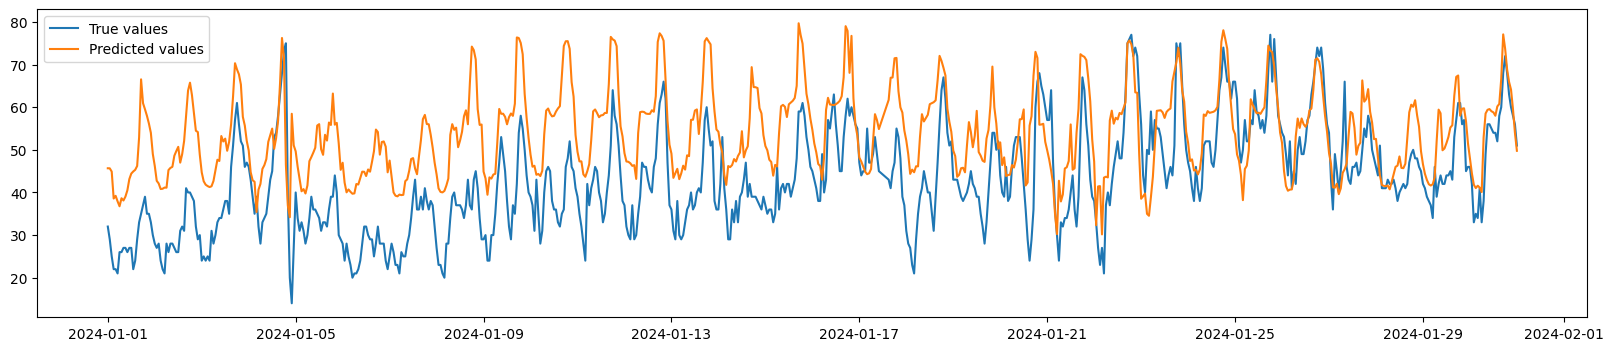

root_mean_squared_error: 19.775551788928556
r2_score: -0.9450164955317244
mean_absolute_error: 16.89963258816707
huber: 3.359981060028076


In [17]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(rfr_pred_df[(rfr_pred_df.index>=start)&(rfr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

rfr_scores={}
for m in metrics:
    rfr_score = m(test_sets[station][agent]['y'],rfr_pred_df)
    print(f'{m.__name__}: {rfr_score}')
    rfr_scores[m.__name__] = rfr_score

In [ ]:
18.900530735030173
r2_score: -0.776719957000005
mean_absolute_error: 15.995552701298633

#### **LSTM**

In [19]:
def buid_lstm_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model

lstm_params = {
    'time_steps': 3,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_absolute_error'
}

lstm_train_params = {
    'epochs':20,
    'batch_size':64,
}

hour_models['LSTM'] = (buid_lstm_model, lstm_params, lstm_train_params, True)

In [20]:
def buid_lstm_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_params2 = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

lstm_train_params2 = {
    'epochs':10,
    'batch_size':32,
}

hour_models['LSTM-old'] = (buid_lstm_model, lstm_params2, lstm_train_params2, True)

##### *Testing...*

In [13]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

ts = lstm_params['time_steps']
lstm_x_train = create_sequences(training_sets[station][agent]['x'], ts)
lstm_y_train = training_sets[station][agent]['y'].iloc[ts:] # for the first `time_steps` values we don't have training samples to predict them

lstm_x_test = pd.concat([training_sets[station][agent]['x'].iloc[-ts:], test_sets[station][agent]['x']]) # to also compute the first days we need time_steps more days
lstm_x_test = create_sequences(lstm_x_test, ts)
lstm_y_test = test_sets[station][agent]['y']

In [14]:
tf.keras.backend.clear_session()  # Reset TensorFlow state
set_random_seed(42) 
lstm_model = buid_lstm_model(**lstm_params)
lstm_model.fit(
    lstm_x_train,
    lstm_y_train,
    **lstm_train_params
)
lstm_pred = lstm_model.predict(lstm_x_test)
lstm_pred_df = pd.DataFrame(lstm_pred, index=lstm_y_test.index)


Epoch 1/20


/home/davide/Desktop/AI/AIII/project/AII-project/aiii-venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


671/671 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 19.5121
Epoch 2/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 10.2526
Epoch 3/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.9133
Epoch 4/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.7059
Epoch 5/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.5546
Epoch 6/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.4333
Epoch 7/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.3408
Epoch 8/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.2749
Epoch 9/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.2134
Epoch 10/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.1607
Epoch 11/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.1198
Epoch 12/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.0744
Epoch 13/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.0327
Epoch 14/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.9950
Epoch 15/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.952

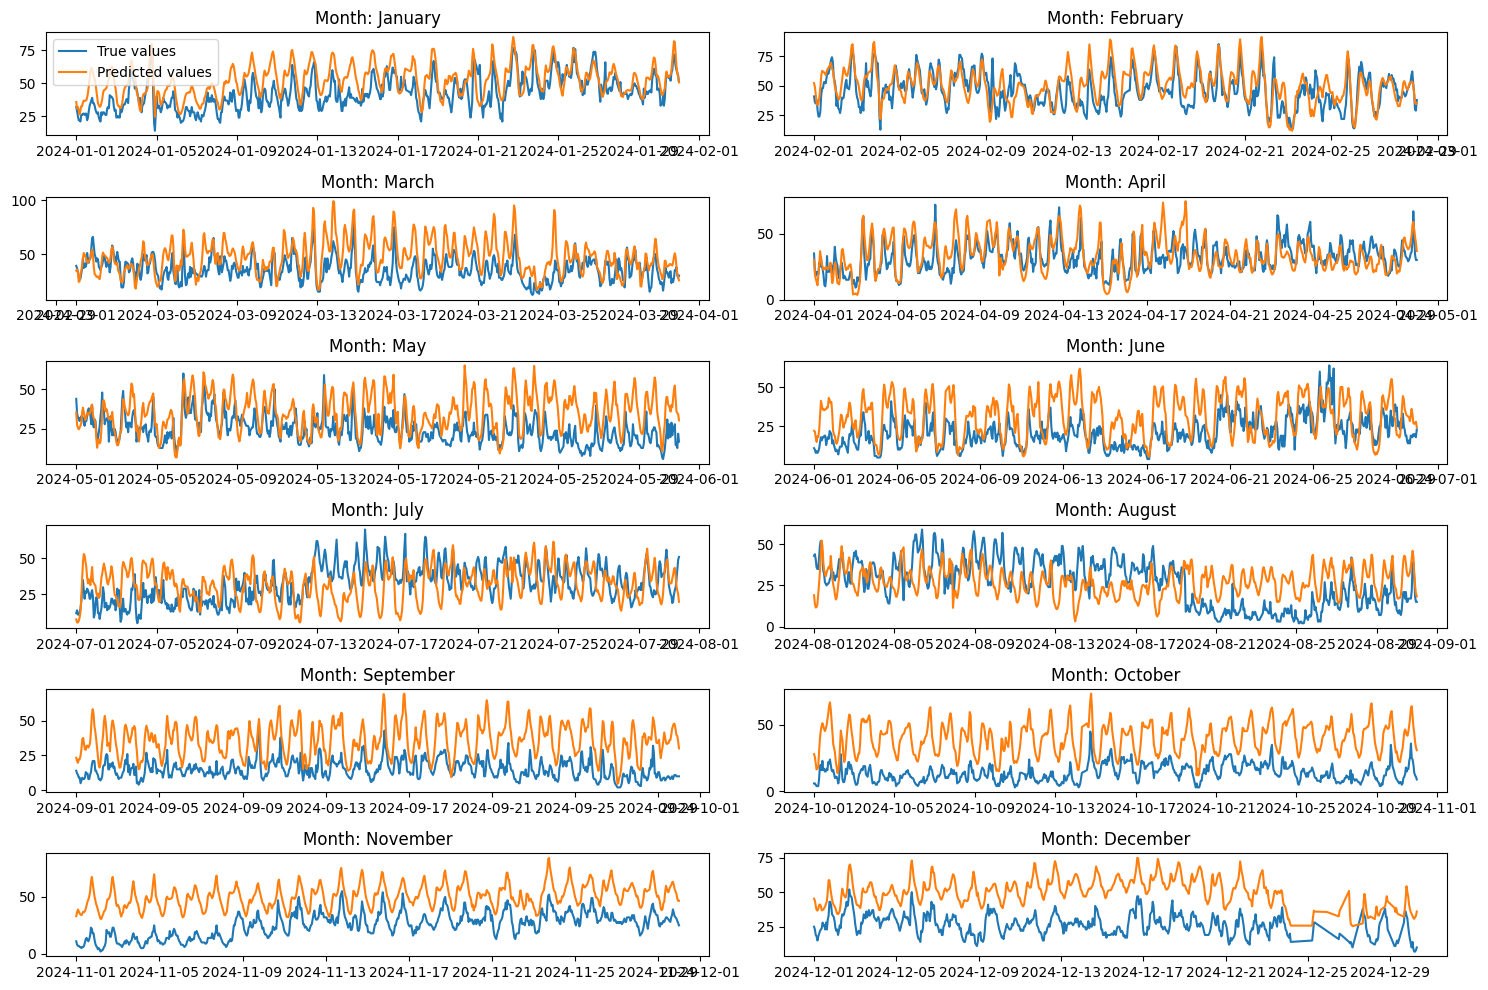

root_mean_squared_error: 18.532959295406645 (13.20888073018875)
r2_score: -0.7082664523478597 (0.07612988515200758)
mean_absolute_error: 15.558753949107508 (10.68102487963084)
huber: 3.091797113418579 (2.116281509399414)


In [69]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 29 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(lstm_y_test[(lstm_y_test.index >= start) & (lstm_y_test.index <= end)], label='True values')
    plt.plot(lstm_pred_df[(lstm_pred_df.index >= start) & (lstm_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()

plt.tight_layout()
plt.show()

lstm_scores={}
for m in metrics:
    a=test_sets[station][agent]['y']
    lstm_score = m(a,lstm_pred_df)
    lstm_score_half = m(a[(a.index>=datetime(2024,1,1))&(a.index<=datetime(2024,5,31))],lstm_pred_df[(lstm_pred_df.index>=datetime(2024,1,1))&(lstm_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {lstm_score} ({lstm_score_half})')
    lstm_scores[m.__name__] = lstm_score

In [ ]:
root_mean_squared_error: 18.532959295406645 (13.20888073018875)
r2_score: -0.7082664523478597 (0.07612988515200758)
mean_absolute_error: 15.558753949107508 (10.68102487963084)
huber: 3.091797113418579 (2.116281509399414)

#### **Feed Forward Neural Network**

In [8]:
def build_ffnn_model(n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(256, activation='relu'),  
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

ffnn_params = {
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

hour_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

##### *Testing...*

In [ ]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

tf.keras.backend.clear_session()  
set_random_seed(42) 
ffnn_model = build_ffnn_model(**ffnn_params)
ffnn_model.fit(
    training_sets[station][agent]['x'], 
    training_sets[station][agent]['y'], 
    **ffnn_train_params
    )
ffnn_pred = ffnn_model.predict(test_sets[station][agent]['x'])
ffnn_pred_df = pd.DataFrame(ffnn_pred, index=test_sets[station][agent]['y'].index)

Epoch 1/10
1343/1343 [==============================] - 6s 4ms/step - loss: 12.5974
Epoch 2/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.5873
Epoch 3/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.3713
Epoch 4/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.2511
Epoch 5/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.2368
Epoch 6/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.1868
Epoch 7/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.1723
Epoch 8/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.1173
Epoch 9/10
1343/1343 [==============================] - 6s 4ms/step - loss: 10.1161
Epoch 10/10
269/269 [==============================] - 0s 1ms/step


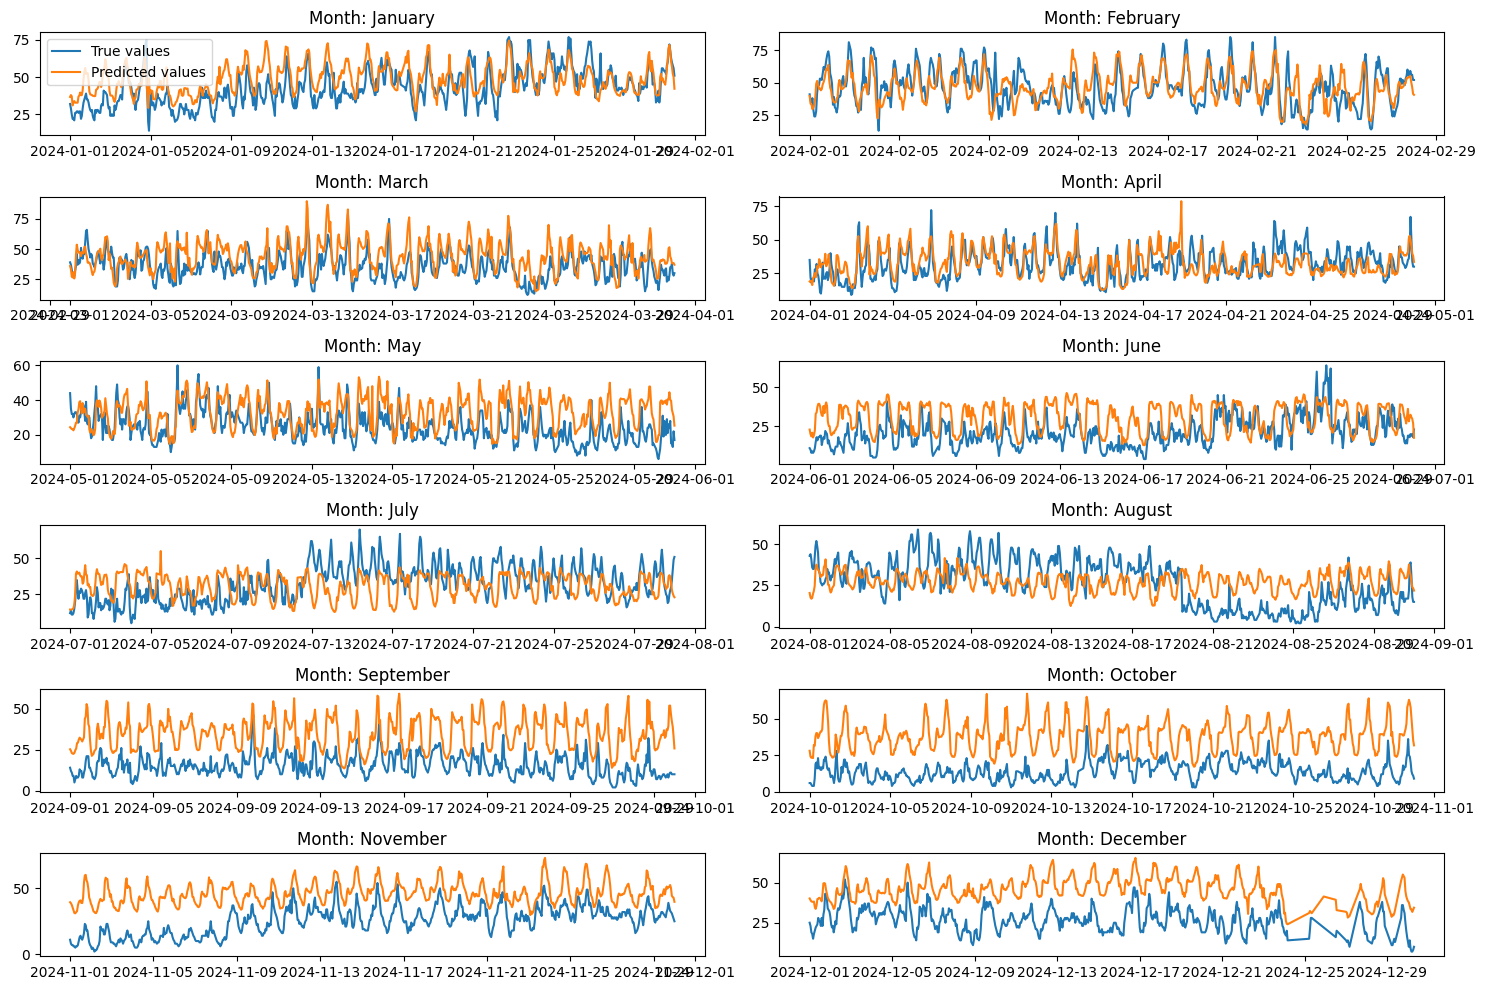

root_mean_squared_error: 16.2906735075959 (11.350533912857719)
r2_score: -0.3199244116491309 (0.3177199276828845)
mean_absolute_error: 13.648944470313774 (9.160393641565589)
huber: 2.709852695465088 (1.8121734857559204)


In [12]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 28 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index >= start) & (test_sets[station][agent]['y'].index <= end)], label='True values')
    plt.plot(ffnn_pred_df[(ffnn_pred_df.index >= start) & (ffnn_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()

plt.tight_layout()
plt.show()

ffnn_scores={}
for m in metrics:
    a=test_sets[station][agent]['y']
    ffnn_score = m(a,ffnn_pred_df)
    ffnn_score_half = m(a[(a.index>=datetime(2024,1,1))&(a.index<=datetime(2024,5,31))],ffnn_pred_df[(ffnn_pred_df.index>=datetime(2024,1,1))&(ffnn_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {ffnn_score} ({ffnn_score_half})')
    ffnn_scores[m.__name__] = ffnn_score

root_mean_squared_error: 14.492155443224677 (10.100927509271882)
r2_score: -0.044568557021160915 (0.4596780454483541)
mean_absolute_error: 12.032431881220456 (8.045476489832241)
huber: 2.3865549564361572 (1.5892049074172974)

#### **Conv1d**

In [9]:
def build_conv_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu',input_shape=(time_steps, n_features)),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(1) 
    ])
    model.compile(optimizer=optimizer, loss=loss)
    return model
conv_params = {
    'time_steps': 24,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}
conv_train_params = {
    'epochs':20,
    'batch_size':64,
}
hour_models['Conv1D'] = (build_conv_model, conv_params, conv_train_params, True)

#### Testing

In [72]:
station = 'PORTA SAN FELICE'
agent = 'NO2'

ts = conv_params['time_steps']
conv_x_train = create_sequences(training_sets[station][agent]['x'], ts)
conv_y_train = training_sets[station][agent]['y'].iloc[ts:] 
conv_x_test = pd.concat([training_sets[station][agent]['x'].iloc[-ts:], test_sets[station][agent]['x']])
conv_x_test = create_sequences(conv_x_test, ts)
conv_y_test = test_sets[station][agent]['y']

tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_model = build_conv_model(**conv_params)
conv_model.fit(conv_x_train, conv_y_train, **conv_train_params)
conv_pred = conv_model.predict(conv_x_test)
conv_pred_df = pd.DataFrame(conv_pred, index=conv_y_test.index)

/home/davide/Desktop/AI/AIII/project/AII-project/aiii-venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 15.3698
Epoch 2/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 11.3971
Epoch 3/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 11.0064
Epoch 4/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.6555
Epoch 5/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.4760
Epoch 6/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 10.3482
Epoch 7/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.2576
Epoch 8/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.0968
Epoch 9/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.9603
Epoch 10/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.8481
Epoch 11/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.7528
Epoch 12/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.6481
Epoch 13/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5225
Epoch 14/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.4017
Epoch 15/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

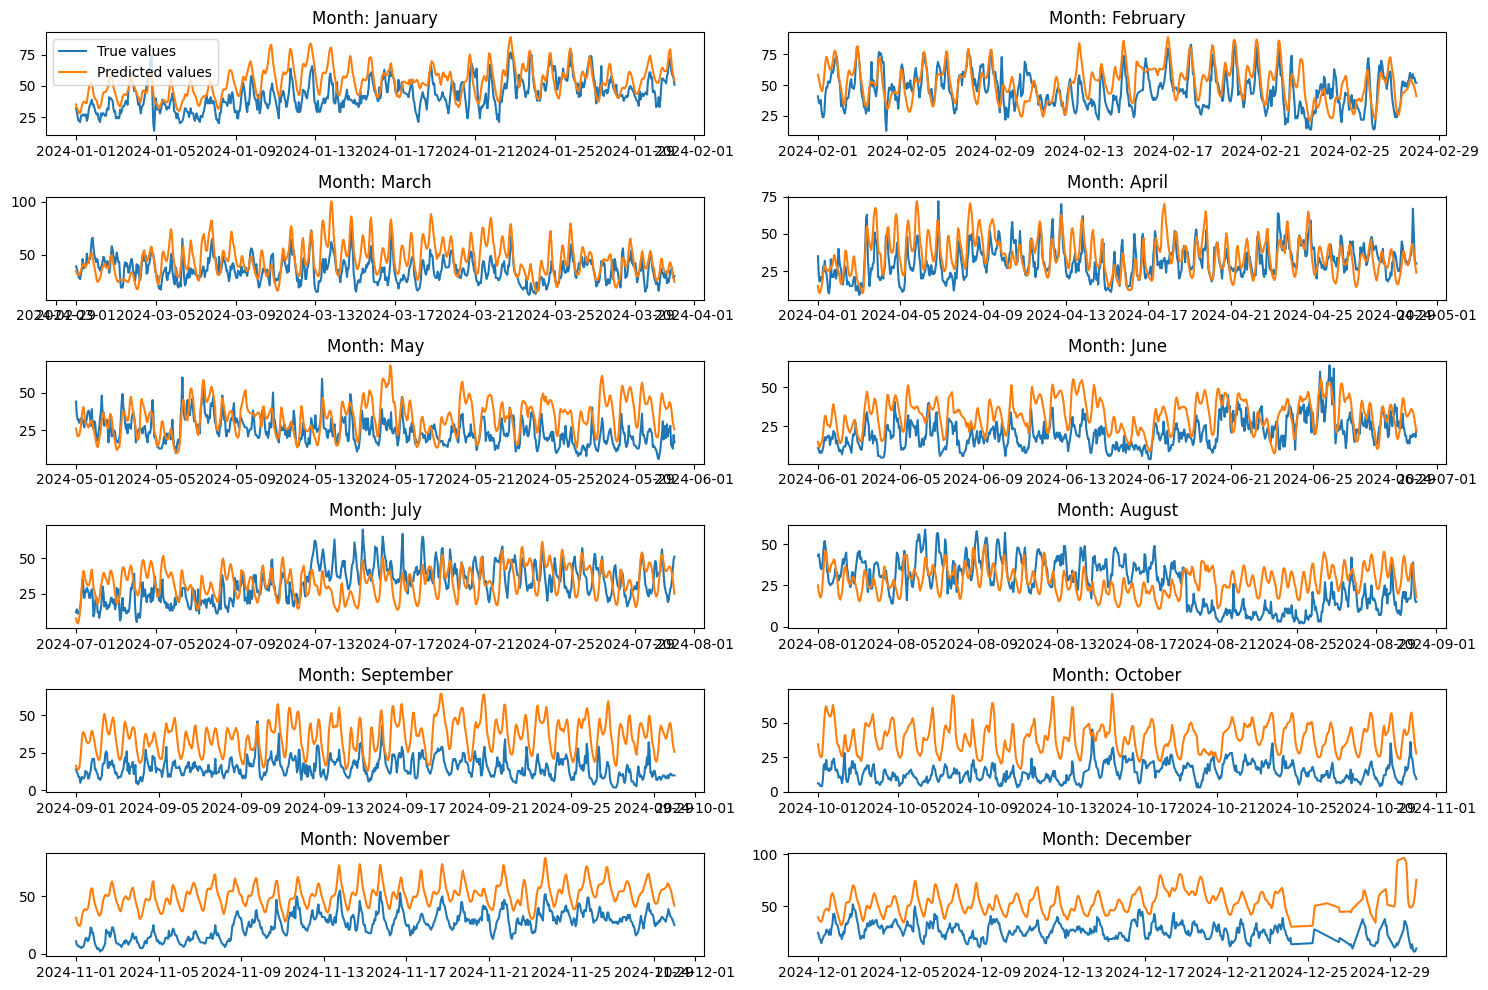

root_mean_squared_error: 18.95401524505629 (13.759434856671016)
r2_score: -0.7867694549458644 (-0.002490057956519909)
mean_absolute_error: 15.851949262946494 (11.07739277007777)
huber: 3.1504342555999756 (2.1955504417419434)


In [49]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 28 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index >= start) & (test_sets[station][agent]['y'].index <= end)], label='True values')
    plt.plot(conv_pred_df[(conv_pred_df.index >= start) & (conv_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()

plt.tight_layout()
plt.show()

ffnn_scores={}
for m in metrics:
    a=test_sets[station][agent]['y']
    ffnn_score = m(a,conv_pred_df)
    ffnn_score_half = m(a[(a.index>=datetime(2024,1,1))&(a.index<=datetime(2024,5,31))],conv_pred_df[(conv_pred_df.index>=datetime(2024,1,1))&(conv_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {ffnn_score} ({ffnn_score_half})')
    ffnn_scores[m.__name__] = ffnn_score

#### Conv1d with residual

In [ ]:
from tensorflow.keras.layers import Input, Add, ReLU, MaxPooling1D, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size):
    res = Conv1D(filters, kernel_size, padding='same', activation='relu')(x)
    res = Conv1D(filters, kernel_size, padding='same')(res)
    x = Conv1D(filters, 1, padding='same')(x)  
    out = Add()([x, res])  
    return ReLU()(out)

def build_conv_res_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    inputs = Input((time_steps, n_features))
    x = Conv1D(32, 3, activation='relu', padding='same')(inputs)
    x = residual_block(x, 32, 3)
    x = MaxPooling1D(2)(x)
    x = residual_block(x, 64, 3)
    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=optimizer, loss=loss)
    return model

conv_res_params = {
    'time_steps': 8,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=3e-3),
    'loss': 'mean_absolute_error'
}
conv_res_train_params = {
    'epochs':20,
    'batch_size':64,
}
hour_models['Conv_res1D'] = (build_conv_res_model, conv_res_params, conv_res_train_params, True)

In [55]:
build_conv_model(5,n_hour_features).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 3, 32)             2336      
                                                                 
 conv1d_8 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12,769
Trainable params: 12,769
Non-trainable params: 0
____________________________________________________

##### *Testing...*

In [ ]:
station = 'PORTA SAN FELICE'
agent = 'NO2'
ts = conv_res_params['time_steps']
conv_res_x_train = create_sequences(training_sets[station][agent]['x'], ts)
conv_res_y_train = training_sets[station][agent]['y'].iloc[ts:] 
conv_res_x_test = pd.concat([training_sets[station][agent]['x'].iloc[-ts:], test_sets[station][agent]['x']])
conv_res_x_test = create_sequences(conv_res_x_test, ts)
conv_res_y_test = test_sets[station][agent]['y']

tf.keras.backend.clear_session()  
set_random_seed(42) 
conv_res_model = build_conv_res_model(**conv_res_params)
conv_res_model.fit(conv_res_x_train, conv_res_y_train, **conv_res_train_params)
conv_res_pred = conv_res_model.predict(conv_res_x_test)
conv_res_pred_df = pd.DataFrame(conv_res_pred, index=conv_res_y_test.index)

Epoch 1/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 13.3919
Epoch 2/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.9552
Epoch 3/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.4840
Epoch 4/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.2019
Epoch 5/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.0733
Epoch 6/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.9586
Epoch 7/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.9156
Epoch 8/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.7557
Epoch 9/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.6483
Epoch 10/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.5632
Epoch 11/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.5380
Epoch 12/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.4311
Epoch 13/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.2881
Epoch 14/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.1757
Epoch 15/20
671/671 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - l

Loss bassissima nel train 

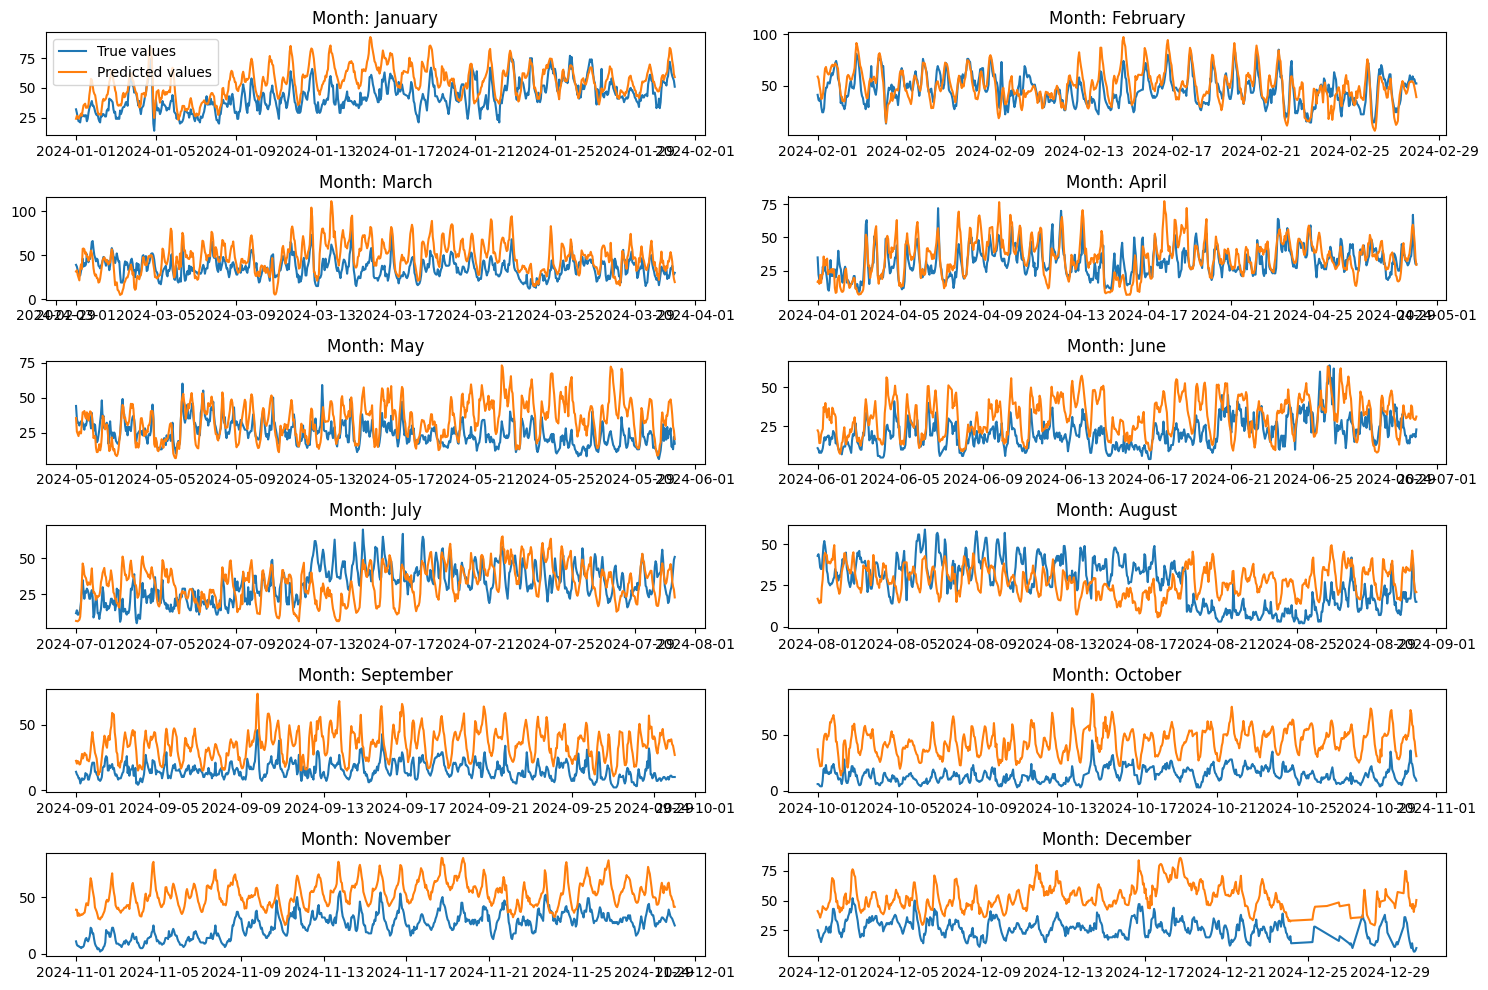

root_mean_squared_error: 19.881771191238045 (14.41317421499315)
r2_score: -0.965966943616237 (-0.10001385068796753)
mean_absolute_error: 16.452521080549488 (11.416257208681715)
huber: 3.2705605030059814 (2.263336420059204)


In [42]:
plt.figure(figsize=(15, 10))

for month in range(1, 13):
    start = datetime(2024, month, 1)
    end = datetime(2024, month, 28 if month == 2 else 30 if month in [4, 6, 9, 11] else 31)
    
    plt.subplot(6, 2, month)
    plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index >= start) & (test_sets[station][agent]['y'].index <= end)], label='True values')
    plt.plot(conv_res_pred_df[(conv_res_pred_df.index >= start) & (conv_res_pred_df.index <= end)], label='Predicted values')
    plt.title(f'Month: {start.strftime("%B")}')
    if month==1:plt.legend()

plt.tight_layout()
plt.show()

ffnn_scores={}
for m in metrics:
    a=test_sets[station][agent]['y']
    ffnn_score = m(a,conv_res_pred_df)
    ffnn_score_half = m(a[(a.index>=datetime(2024,1,1))&(a.index<=datetime(2024,5,31))],conv_res_pred_df[(conv_res_pred_df.index>=datetime(2024,1,1))&(conv_res_pred_df.index<=datetime(2024,5,31))])
    print(f'{m.__name__}: {ffnn_score} ({ffnn_score_half})')
    ffnn_scores[m.__name__] = ffnn_score

#### **XGBoost**

In [45]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 180,
    'max_depth': 6,
    'learning_rate': 0.07,
    'subsample': 0.9,
    'random_state': RANDOM_STATE,
}

hour_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

##### *Testing...*

In [75]:
agent = 'PORTA SAN FELICE'
agent = 'NO2'

xgbr_model = xgb.XGBRegressor(**xgbr_params)
xgbr_model.fit(training_sets[station][agent]['x'], training_sets[station][agent]['y'])
xgbr_pred = xgbr_model.predict(test_sets[station][agent]['x'])
xgbr_pred_df = pd.DataFrame(xgbr_pred, index=test_sets[station][agent]['y'].index)

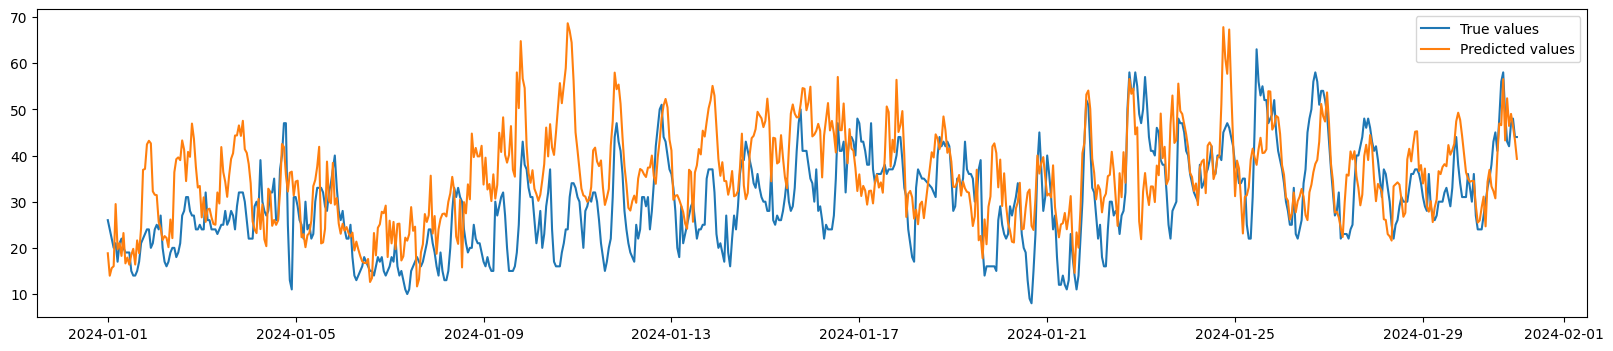

root_mean_squared_error: 8.510071965124986
r2_score: 0.3405075443667299
mean_absolute_error: 6.351526721612011
mean_absolute_percentage_error: 187725041127808.9


In [ ]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values')
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='Predicted values')
plt.legend()
plt.show()

xgbr_scores={}
for m in metrics:
    xgbr_score = m(test_sets[station][agent]['y'],xgbr_pred_df)
    print(f'{m.__name__}: {xgbr_score}')
    xgbr_scores[m.__name__] = xgbr_score

#### **Test comparisons**

Assuming that the predictions are on the same station and agent.

NameError: name 'ffnn_pred_df' is not defined

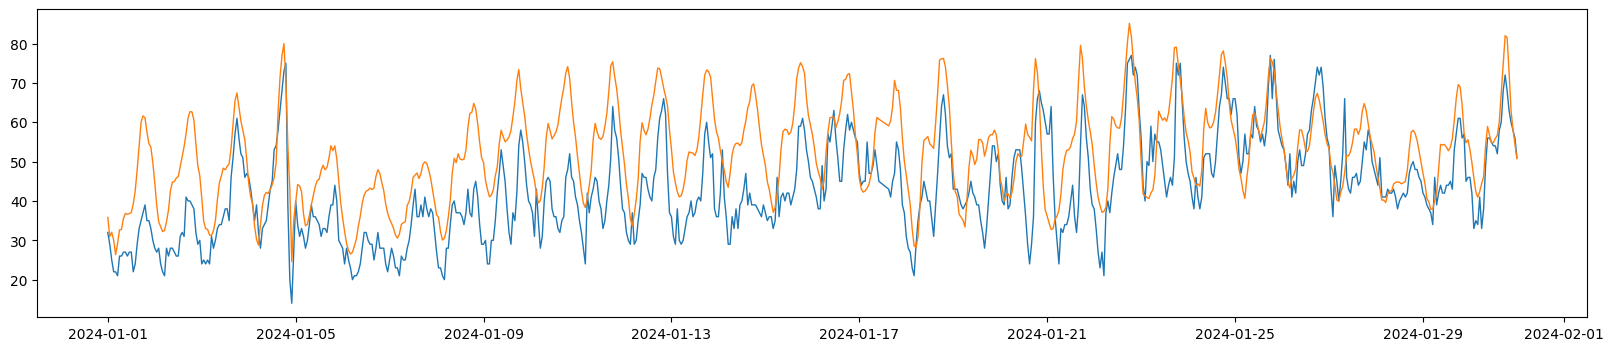

In [76]:
start = datetime(2024,1,1)
end = datetime(2024,1,31)

plt.figure(figsize=figsize)
plt.plot(test_sets[station][agent]['y'][(test_sets[station][agent]['y'].index>=start)&(test_sets[station][agent]['y'].index<=end)], label='True values', linewidth=1)
plt.plot(lstm_pred_df[(lstm_pred_df.index>=start)&(lstm_pred_df.index<=end)], label='LSTM', linewidth=1)
plt.plot(ffnn_pred_df[(ffnn_pred_df.index>=start)&(ffnn_pred_df.index<=end)], label='ffnn values', linewidth=1)
plt.plot(xgbr_pred_df[(xgbr_pred_df.index>=start)&(xgbr_pred_df.index<=end)], label='xgb values', linewidth=1)
plt.plot(rfr_pred_df[(rfr_pred_df.index>=start)&(rfr_pred_df.index<=end)], label='rf values', linewidth=1)
# plt.xlim(test_sets[station][agent]['y'].index[0],test_sets[station][agent]['y'].index[-1])
plt.legend()
plt.show()

for m in metrics:
    name = m.__name__
    print(f'{name}:')
    print(f' - LSTM: {lstm_scores[name]}')
    print(f' - FFNN: {ffnn_scores[name]}')
    print(f' - XGB: {xgbr_scores[name]}')
    print(f' - RF: {rfr_scores[name]}')

ziocane ffnn ha gli errori più bassi di tutti ma fa merda

## **Daily agents**

In [57]:
daily_models = {} # contains tuples: (ModelClass, model_params:dict, training_params:dict, sequences:bool|dict)

**NOTE:** For now, I simply copied the one above

#### **Random Forest Regressor**

In [58]:
rfr_params = {
    'n_estimators':100,
    'max_depth':10
}

daily_models['Random Forest Regressor'] = (RandomForestRegressor, rfr_params, None, False)

#### **XGBoost Regressor**

In [59]:
xgbr_params = {
    'objective': "reg:squarederror",
    'n_estimators': 100,
    # 'max_depth': 20
}

daily_models['XGB Regressor'] = (xgb.XGBRegressor, xgbr_params, None, False)

#### **LSTM**

In [60]:
def buid_lstm_model(time_steps, n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=(time_steps, n_features)),
        # Dropout(0.2),
        # LSTM(50, return_sequences=False),
        # Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_params = {
    'time_steps': 1, #NOTE is set to 1 cause no causality
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

lstm_train_params = {
    'epochs':10,
    'batch_size':32,
}

daily_models['LSTM'] = (buid_lstm_model, lstm_params, lstm_train_params, True)

In [61]:
lstm_params_huber = {
    'time_steps': 1, #NOTE is set to 1 cause no causality
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': tf.keras.losses.Huber(delta=0.2)
}

daily_models['LSTM-huber'] = (buid_lstm_model, lstm_params_huber, lstm_train_params, True)

#### FFNN

In [62]:
def build_ffnn_model(n_features, optimizer='adam', loss='mean_absolute_error'):
    model = Sequential([
        Dense(1024, activation='relu', input_shape=(n_features,)),
        Dropout(0.2),
        Dense(512, activation='relu'), 
        Dropout(0.2),
        Dense(256, activation='relu'),  
        Dropout(0.2),
        Dense(128, activation='relu'),  
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

ffnn_params = {
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': 'mean_absolute_error'
}

ffnn_train_params = {
    'epochs':10,
    'batch_size':32,
}

daily_models['Feed Forward NN'] = (build_ffnn_model, ffnn_params, ffnn_train_params, False)

In [63]:
ffnn_params_huber = {
    'n_features': n_daily_features,
    'optimizer': Adam(learning_rate=1e-2),
    'loss': tf.keras.losses.Huber(delta=0.2)
}


daily_models['Feed Forward NN-huber'] = (build_ffnn_model, ffnn_params_huber, ffnn_train_params, False)

## **Agents Evaluations**

### Hour Models

In [14]:
def buid_lstm_2_model(time_steps, n_features, optimizer='adam', loss='mean_squared_error'):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(time_steps, n_features)),
        LSTM(32, return_sequences=False),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=optimizer, loss=loss)

    return model

lstm_2_params = {
    'time_steps': 5,
    'n_features': n_hour_features,
    'optimizer': Adam(learning_rate=1e-3),
    'loss': 'mean_squared_error'
}

lstm_2_train_params = {
    'epochs':20,
    'batch_size':32,
}

hour_models['LSTM_2'] = (buid_lstm_2_model, lstm_2_params, lstm_2_train_params, True)


In [21]:
hour_results = train_models(
    hour_models,training_sets,test_sets,metrics,
    to_execute={
        'agents':'all',
        'stations':'all',
        'models':'all',
    },
    ignore={
        'stations':[],
        'agents':['PM10','PM2.5'],
        'models':[]
        },
    random_state=RANDOM_STATE,
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['O3', 'C6H6', 'CO', 'NO2']
models: ['Feed Forward NN', 'Conv1D', 'Conv_res1D', 'XGB Regressor', 'Feed Forward NN 2', 'Feed Forward NN 3', 'LSTM_2', 'LSTM_3', 'Random Forest Regressor 2', 'Random Forest Regressor 3', 'Random Forest Regressor 4', 'Random Forest Regressor 5', 'Random Forest Regressor 6', 'XGB Regressor 2', 'XGB Regressor 3', 'XGB Regressor 4', 'XGB Regressor 5', 'XGB Regressor 6', 'XGB Regressor 7', 'XGB Regressor 8', 'XGB Regressor 9', 'XGB Regressor 10', 'LSTM', 'LSTM-old']
Agent O3
> Feed Forward NN model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station VIA CHIARINI...
> Conv1D model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station VIA CHIARINI...
> Conv_res1D model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station VIA CHIARINI...
> XGB Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station VIA CHIAR

In [42]:
hour_extracted_data = extract_data(hour_results)
# hour_extracted_data.sort_values(by=[])
hour_extracted_data.loc[hour_extracted_data.groupby(by=['Station','Agent'])['root_mean_squared_error'].idxmin()]

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
46,GIARDINI MARGHERITA,NO2,LSTM,6.725825,0.595120,4.597018,0.899681
23,GIARDINI MARGHERITA,O3,LSTM-old,12.410668,0.879252,9.256034,1.831409
70,PORTA SAN FELICE,C6H6,LSTM,0.416556,0.649483,0.258733,0.036210
72,PORTA SAN FELICE,CO,Feed Forward NN,0.204953,0.582798,0.156169,0.016358
101,PORTA SAN FELICE,NO2,Feed Forward NN 3,13.114711,0.144562,10.671010,2.114276
144,VIA CHIARINI,NO2,Feed Forward NN,6.317758,0.636529,4.774240,0.935024
126,VIA CHIARINI,O3,LSTM_2,12.797524,0.872805,9.610663,1.902263


In [53]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(hour_extracted_data[hour_extracted_data['Model'].str.startswith('Con')].sort_values(by=['Station','Agent','root_mean_squared_error']))

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
26,GIARDINI MARGHERITA,NO2,Conv_res1D,7.229194,0.532249,4.931438,0.966590
25,GIARDINI MARGHERITA,NO2,Conv1D,7.244072,0.530322,5.179939,1.016199
2,GIARDINI MARGHERITA,O3,Conv_res1D,12.849004,0.870572,9.580384,1.896327
1,GIARDINI MARGHERITA,O3,Conv1D,15.204071,0.818779,11.479322,2.275982
50,PORTA SAN FELICE,C6H6,Conv_res1D,0.418998,0.645362,0.260635,0.036577
49,PORTA SAN FELICE,C6H6,Conv1D,0.453551,0.584459,0.293344,0.042471
74,PORTA SAN FELICE,CO,Conv_res1D,0.216811,0.533125,0.168137,0.018820
73,PORTA SAN FELICE,CO,Conv1D,0.247258,0.392792,0.197082,0.023376
97,PORTA SAN FELICE,NO2,Conv1D,19.325002,-0.857420,15.790941,3.138250
98,PORTA SAN FELICE,NO2,Conv_res1D,21.226036,-1.240829,17.845299,3.549104


##### **EXAMPLE:** how to eventually try new metrics

In [ ]:
from sklearn.metrics import mean_squared_error

metrics.append(mean_squared_error) # even if you append multiple times, the result is written on a dict so there are no duplicates. Anyways, be careful :)

In [ ]:
new_hour_results = update_metrics(hour_results, test_sets, metrics)
new_hour_extracted_data = extract_data(new_hour_results)
new_hour_extracted_data.sort_values(by=['Agent','Model','Station'])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,mean_squared_error
1,GIARDINI MARGHERITA,NO2,XGB Regressor,7.693566,0.470227,5.591722,59.190959
3,VIA CHIARINI,NO2,XGB Regressor,8.510072,0.340508,6.351527,72.421325
0,GIARDINI MARGHERITA,O3,XGB Regressor,14.529542,0.834502,10.980940,211.107599
2,VIA CHIARINI,O3,XGB Regressor,14.504967,0.836600,10.876629,210.394056


### Daily Models

In [65]:
daily_results = train_models(
    daily_models,training_sets,test_sets,metrics,
    to_execute={
        'agents':['PM10','PM2.5'],
        'stations':'all',
        'models':'all',
        },
    ignore={
        'stations':[],
        'agents':[],
        'models':[]
        },
    v=1
)

Train settings:
stations: ['GIARDINI MARGHERITA', 'PORTA SAN FELICE', 'VIA CHIARINI']
agents: ['PM10', 'PM2.5']
models: ['Random Forest Regressor', 'XGB Regressor', 'LSTM', 'LSTM-huber', 'Feed Forward NN', 'Feed Forward NN-huber']
Agent PM10
> Random Forest Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> XGB Regressor model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> LSTM model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> LSTM-huber model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> Feed Forward NN model:
 >> Training station GIARDINI MARGHERITA...
 >> Training station PORTA SAN FELICE...
 >> Training station VIA CHIARINI...
> Feed Forward NN-huber model:
 >

In [66]:
updated_daily_results = update_metrics(daily_results, test_sets, []) # an empty list simply wont add metrics
daily_extracted_data = extract_data(updated_daily_results)
daily_extracted_data.sort_values(by=['Agent','Station','root_mean_squared_error'])

,Station,Agent,Model,root_mean_squared_error,r2_score,mean_absolute_error,huber
3,GIARDINI MARGHERITA,PM10,LSTM-huber,10.470269,0.410487,7.347315,1.449533
2,GIARDINI MARGHERITA,PM10,LSTM,10.501312,0.406986,7.347784,1.449703
0,GIARDINI MARGHERITA,PM10,Random Forest Regressor,10.973423,0.352467,7.846419,1.549326
5,GIARDINI MARGHERITA,PM10,Feed Forward NN-huber,11.366221,0.305280,7.592684,1.498721
4,GIARDINI MARGHERITA,PM10,Feed Forward NN,11.655945,0.269412,7.785575,1.537294
1,GIARDINI MARGHERITA,PM10,XGB Regressor,11.876537,0.241497,8.432104,1.666638
16,PORTA SAN FELICE,PM10,Feed Forward NN,10.464675,0.537589,7.284393,1.437192
17,PORTA SAN FELICE,PM10,Feed Forward NN-huber,10.646005,0.521426,7.650002,1.510115
12,PORTA SAN FELICE,PM10,Random Forest Regressor,11.116113,0.478226,7.560720,1.492417
15,PORTA SAN FELICE,PM10,LSTM-huber,11.236663,0.466848,7.732830,1.526762
